In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 100
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
import seaborn as sns
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Ссылка на соревнование Kaggle https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/

<h3 align='left'>Функция формирования посылки на Kaggle</h3>

In [2]:
def kaggle_sub(y_pred):
    sub = pd.read_csv('sample_submission.csv')
    sub['SalePrice'] = y_pred
    sub.to_csv('prediction.csv', index=False)

<h3 align='left'>Считывание и начальная предобработка данных</h3>

In [3]:
X_train_full = train = pd.read_csv('train.csv', index_col='Id')
X_test = pd.read_csv('test.csv', index_col='Id')

In [4]:
X_train_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


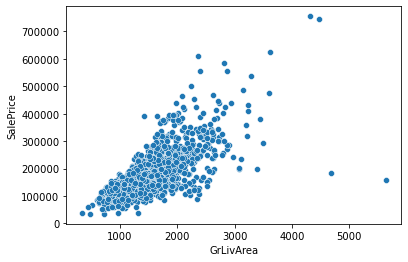

In [5]:
#Зависимость жилой площади от цены
sns.scatterplot(x=X_train_full['GrLivArea'], y=X_train_full['SalePrice']);

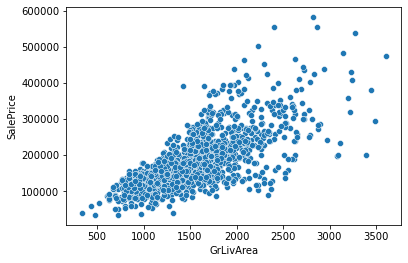

In [6]:
#Удаляем выбросы 
X_train_full = X_train_full.query('GrLivArea < 4000 & SalePrice <600000')
sns.scatterplot(x=X_train_full['GrLivArea'], y=X_train_full['SalePrice']);

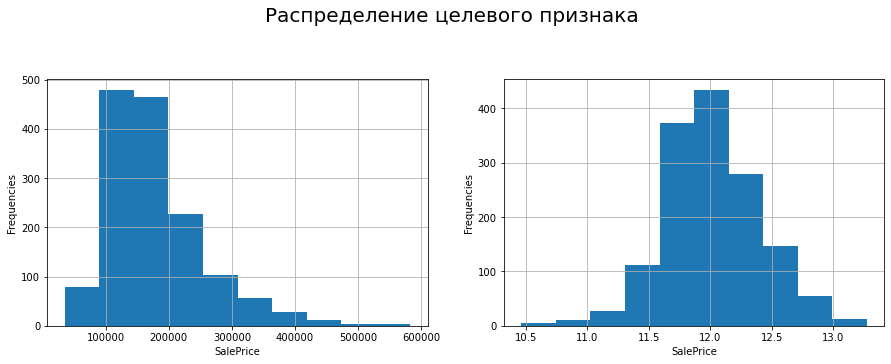

In [7]:
#Распределение целевого признака
plt.figure(figsize=(15, 10)).suptitle('Распределение целевого признака', fontsize = 20)   
plt.subplot(2, 2, 1)
X_train_full['SalePrice'].hist()
plt.xlabel('SalePrice')
plt.ylabel('Frequencies');

#Стабилизируем дисперсию
y_train_full = np.log1p(X_train_full['SalePrice'])

plt.subplot(2, 2, 2)
y_train_full.hist()
plt.xlabel('SalePrice')
plt.ylabel('Frequencies');

In [8]:
data = pd.concat([X_train_full, X_test], axis=0).drop('SalePrice', axis=1)
train_size = X_train_full.shape[0]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2913 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2913 non-null   int64  
 1   MSZoning       2909 non-null   object 
 2   LotFrontage    2427 non-null   float64
 3   LotArea        2913 non-null   int64  
 4   Street         2913 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2913 non-null   object 
 7   LandContour    2913 non-null   object 
 8   Utilities      2911 non-null   object 
 9   LotConfig      2913 non-null   object 
 10  LandSlope      2913 non-null   object 
 11  Neighborhood   2913 non-null   object 
 12  Condition1     2913 non-null   object 
 13  Condition2     2913 non-null   object 
 14  BldgType       2913 non-null   object 
 15  HouseStyle     2913 non-null   object 
 16  OverallQual    2913 non-null   int64  
 17  OverallCond    2913 non-null   int64  
 18  YearBuil

<h3 align='left'>Предобработка </h3>

In [10]:
#Смотрим процент NA-значений в признаках
na_features_perc = pd.DataFrame({'NA_count': 100 * data.isnull().sum().sort_values(ascending=False) / data.shape[0]})
na_features_perc = na_features_perc.query('NA_count > 0')
na_features_perc

,NA_count
PoolQC,99.725369
MiscFeature,96.395469
Alley,93.202884
Fence,80.432544
FireplaceQu,48.746996
LotFrontage,16.683831
GarageYrBlt,5.458290
GarageFinish,5.458290
GarageQual,5.458290
GarageCond,5.458290


In [11]:
na_features_perc.index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType',
       'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MasVnrType', 'MasVnrArea', 'MSZoning', 'Functional', 'BsmtHalfBath',
       'BsmtFullBath', 'Utilities', 'SaleType', 'BsmtFinSF1', 'KitchenQual',
       'GarageCars', 'BsmtUnfSF', 'TotalBsmtSF', 'Exterior2nd', 'Exterior1st',
       'GarageArea', 'Electrical', 'BsmtFinSF2'],
      dtype='object')

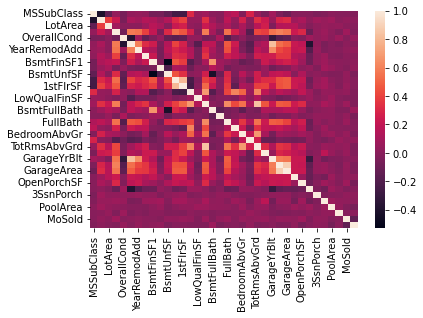

In [12]:
#График корреляции данных
sns.heatmap(data.iloc[:train_size, :].corr());

Переменные, где есть NA-значения чаще всего обозначают, что в продаваемом доме отсутствуют данные постройки/функции

In [13]:
#Заменяем NA-значения в зависимости от типа переменной

for i in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
          'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType', 'MSSubClass', 'BsmtExposure',
         'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2'):
    data[i] = data[i].fillna('None')

    
for i in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
          'BsmtHalfBath', 'MasVnrArea'):
    data[i] = data[i].fillna(0)

for i in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional'):
    data[i] = data[i].fillna(data[i].mode()[0])

data["LotFrontage"] = data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))


In [14]:
data['Utilities'].value_counts()

AllPub    2910
NoSeWa       1
Name: Utilities, dtype: int64

In [15]:
data = data.drop('Utilities', axis=1) #так как почти все значения одинаковы, удаляем переменную

In [16]:
#NA-значения отсутствуют
na_features_perc = pd.DataFrame({'NA_count': 100 * data.isnull().sum().sort_values(ascending=False) / data.shape[0]})
na_features_perc = na_features_perc.query('NA_count > 0')
na_features_perc

,NA_count


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2913 entries, 1 to 2919
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2913 non-null   int64  
 1   MSZoning       2913 non-null   object 
 2   LotFrontage    2913 non-null   float64
 3   LotArea        2913 non-null   int64  
 4   Street         2913 non-null   object 
 5   Alley          2913 non-null   object 
 6   LotShape       2913 non-null   object 
 7   LandContour    2913 non-null   object 
 8   LotConfig      2913 non-null   object 
 9   LandSlope      2913 non-null   object 
 10  Neighborhood   2913 non-null   object 
 11  Condition1     2913 non-null   object 
 12  Condition2     2913 non-null   object 
 13  BldgType       2913 non-null   object 
 14  HouseStyle     2913 non-null   object 
 15  OverallQual    2913 non-null   int64  
 16  OverallCond    2913 non-null   int64  
 17  YearBuilt      2913 non-null   int64  
 18  YearRemo

In [18]:
#Label Encoding категориальных признаков
X_train_full = data.iloc[:train_size, :]
X_test = data.iloc[train_size:, :]
for i in data.columns:
    if data[i].dtype == 'object':
        le = LabelEncoder()
        X_train_full[i] = le.fit_transform(X_train_full[i])
        X_test[i] = le.transform(X_test[i])

<h3 align='left'>Подготовка данных</h3>

In [19]:
##Разделяем train, valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=17) 

In [20]:
#Задаем кросс-валидатор и диапазон значений гиперпараметров для поиска 
cv = KFold(shuffle=True)

RF_params = {
    'max_depth': range(3, 15, 2),
    'min_samples_leaf': range(1, 4),
    'min_samples_split': range(2, 8, 2),
    
}

GB_params = {
    'learning_rate': np.arange(0.05, 0.35, 0.05),
    'max_depth': range(3, 15, 2),
    'min_child_weight': range(3, 9, 2),
    'gamma': np.arange(0, 0.5, 0.1),
    'colsample_bytree': np.arange(0.3, 0.8, 0.1)
}

## RandomForest

In [34]:
rf_reg = RandomForestRegressor(n_estimators=200)
rf_searh = RandomizedSearchCV(rf_reg, RF_params, cv=cv, n_jobs=-1, random_state=17)
rf_searh.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=RandomState(MT19937) at 0x2085240E940,
   shuffle=True),
                   estimator=RandomForestRegressor(n_estimators=200), n_jobs=-1,
                   param_distributions={'max_depth': range(3, 15, 2),
                                        'min_samples_leaf': range(1, 4),
                                        'min_samples_split': range(2, 8, 2)},
                   random_state=17)

In [35]:
rf_prediction = rf_searh.predict(X_valid)
mean_squared_error(y_valid, rf_prediction)

0.01661489247906781

## XGBRegressor

In [36]:
xgb_reg = XGBRegressor(n_estimators=200)
xgb_searh = RandomizedSearchCV(xgb_reg, GB_params, cv=cv, n_jobs=-1, random_state=17)
xgb_searh.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=RandomState(MT19937) at 0x2085240E940,
   shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_st...
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate_param

In [37]:
xgb_prediction = xgb_searh.predict(X_valid)
mean_squared_error(y_valid, xgb_prediction)

0.014061682053819692

## LGBMRegressor

In [38]:
lgb_reg = LGBMRegressor(n_estimators=200)
lgb_searh = RandomizedSearchCV(lgb_reg, GB_params, cv=cv, n_jobs=-1, random_state=17)
lgb_searh.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=RandomState(MT19937) at 0x2085240E940,
   shuffle=True),
                   estimator=LGBMRegressor(n_estimators=200), n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.3, 0.4, 0.5, 0.6, 0.7]),
                                        'gamma': array([0. , 0.1, 0.2, 0.3, 0.4]),
                                        'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
                                        'max_depth': range(3, 15, 2),
                                        'min_child_weight': range(3, 9, 2)},
                   random_state=17)

In [46]:
lgb_prediction = lgb_searh.predict(X_valid)
mean_squared_error(y_valid, lgb_prediction)

0.013581310568143481

## Stacking

In [42]:
estimators = [
        ('xgb', XGBRegressor(n_estimators=2000, **xgb_searh.best_params_, random_state=17)),
        ('lgb', LGBMRegressor(n_estimators=2000, **lgb_searh.best_params_, random_state=17)),
        ('rf', RandomForestRegressor(n_estimators=2000, **rf_searh.best_params_, random_state=17))]


stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), cv=cv, n_jobs=-1)
stack.fit(X_train, y_train)
stack_prediction = stack.predict(X_valid)
mean_squared_error(y_valid, stack_prediction)

0.013393626011955444

При стекинге результат улучшается, поэтому обучим модель стекинга на всех данных

## Submission

In [43]:
stack.fit(X_train_full, y_train_full)
stack_prediction = stack.predict(X_test)

In [44]:
kaggle_sub(np.expm1(stack_prediction))

#0.12868 Total RMSE 